VISUAL QUESTION ANSWERING

In [ ]:
import os
import subprocess
import sys

print("Installing dependencies")
commands = [
    "pip uninstall -y bigframes", # Remove common conflict on Colab
    "pip install -q -U bitsandbytes",
    "pip install -q -U git+https://github.com/huggingface/transformers.git",
    "pip install -q -U git+https://github.com/huggingface/accelerate.git",
    "pip install -q -U datasets evaluate matplotlib seaborn pyarrow"
]

for cmd in commands:
    subprocess.check_call(cmd, shell=True)

print("Dependencies installed.")

Installing dependencies
Dependencies installed.


Extracted.
Extracted.
Successfully loaded 50 VQA v2 samples.


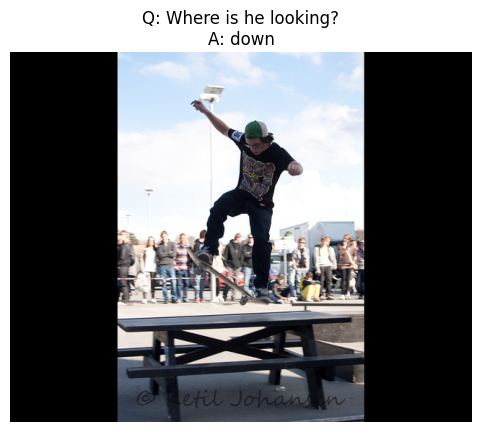

In [ ]:
# LOAD VQA v2 DATA ---
import os
import json
import requests
import zipfile
import io
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

# 1. Download Official Annotations
def download_and_extract(url, save_path):
    print(f"Downloading {url}")
    r = requests.get(url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall(save_path)
    print("Extracted.")

data_dir = "./vqa_data"
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
    # Official VQA v2 Validation URLs (S3)
    download_and_extract("https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Questions_Val_mscoco.zip", data_dir)
    download_and_extract("https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Annotations_Val_mscoco.zip", data_dir)

# 2. Custom Dataset Class for Real VQA Data
class OfficialVQADataset(Dataset):
    def __init__(self, data_dir, split='val2014', limit=None):
        # Load Questions
        q_path = f"{data_dir}/v2_OpenEnded_mscoco_{split}_questions.json"
        with open(q_path, 'r') as f:
            self.questions = json.load(f)['questions']

        # Load Answers
        a_path = f"{data_dir}/v2_mscoco_{split}_annotations.json"
        with open(a_path, 'r') as f:
            self.annotations = json.load(f)['annotations']

        # Create Map
        self.q_map = {x['question_id']: x for x in self.questions}
        self.a_map = {x['question_id']: x for x in self.annotations}
        self.ids = list(self.q_map.keys())

        if limit:
            self.ids = self.ids[:limit]

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        qid = self.ids[idx]
        q_data = self.q_map[qid]
        a_data = self.a_map[qid]

        # Get Image URL (COCO Standard)
        img_id = q_data['image_id']
        img_url = f"http://images.cocodataset.org/val2014/COCO_val2014_{img_id:012d}.jpg"

        # Load Image on the fly
        try:
            img = Image.open(requests.get(img_url, stream=True).raw).convert('RGB')
        except:
            img = Image.new('RGB', (224, 224), color='gray') # Fallback if connection drops

        return {
            'image': img,
            'question': q_data['question'],
            'answer': a_data['multiple_choice_answer'], # Primary ground truth
            'valid_answers': [x['answer'] for x in a_data['answers']] # All annotator answers
        }

# Load Dataset
dataset = OfficialVQADataset(data_dir, limit=50) # 50 Real samples
print(f"Successfully loaded {len(dataset)} VQA v2 samples.")

# EDA: Visualize
sample = dataset[0]
plt.imshow(sample['image'])
plt.axis('off')
plt.title(f"Q: {sample['question']}\nA: {sample['answer']}")
plt.show()

In [ ]:
# LOAD & CLEAN DATA
import os
import json
import requests
import zipfile
import io
from PIL import Image
from torch.utils.data import Dataset
from tqdm import tqdm
import pandas as pd

# 1. Download Official Annotations
data_dir = "./vqa_data"
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
    print("Downloading VQA v2 Data")
    r = requests.get("https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Questions_Val_mscoco.zip")
    zipfile.ZipFile(io.BytesIO(r.content)).extractall(data_dir)
    r = requests.get("https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Annotations_Val_mscoco.zip")
    zipfile.ZipFile(io.BytesIO(r.content)).extractall(data_dir)
    print("Downloads complete.")

# 2. Dataset Class
class OfficialVQADataset(Dataset):
    def __init__(self, data_dir, limit=None):
        with open(f"{data_dir}/v2_OpenEnded_mscoco_val2014_questions.json") as f:
            self.questions = json.load(f)['questions']
        with open(f"{data_dir}/v2_mscoco_val2014_annotations.json") as f:
            self.annotations = json.load(f)['annotations']

        self.q_map = {x['question_id']: x for x in self.questions}
        self.a_map = {x['question_id']: x for x in self.annotations}
        self.ids = list(self.q_map.keys())
        if limit: self.ids = self.ids[:limit]

    def __len__(self): return len(self.ids)

    def __getitem__(self, idx):
        qid = self.ids[idx]
        q_data = self.q_map[qid]
        img_url = f"http://images.cocodataset.org/val2014/COCO_val2014_{q_data['image_id']:012d}.jpg"

        try:
            # Stream image with timeout
            resp = requests.get(img_url, stream=True, timeout=5)
            if resp.status_code == 200:
                img = Image.open(resp.raw).convert('RGB')
            else:
                return None # Mark as failed
        except:
            return None

        return {
            'image': img,
            'question': q_data['question'],
            'answer': self.a_map[qid]['multiple_choice_answer'],
            'valid_answers': [x['answer'] for x in self.a_map[qid]['answers']]
        }

# 3. Load & Clean
raw_limit = 500 # Requested increase
print(f"Loading {raw_limit} samples")
raw_dataset = OfficialVQADataset(data_dir, limit=raw_limit)

# Filter out failed downloads
valid_data = []
print("Validating images")
for i in tqdm(range(len(raw_dataset))):
    item = raw_dataset[i]
    if item is not None:
        valid_data.append(item)

dataset = valid_data
print(f"\n Cleaned Dataset Ready: {len(dataset)} valid samples (dropped {raw_limit - len(dataset)} bad links).")

Loading 500 samples
Validating images


100%|██████████| 500/500 [01:58<00:00,  4.23it/s]



 Cleaned Dataset Ready: 500 valid samples (dropped 0 bad links).


/tmp/ipython-input-1133917212.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[x[0] for x in type_counts], y=[x[1] for x in type_counts], palette="viridis")


Text(0, 0.5, 'Frequency')

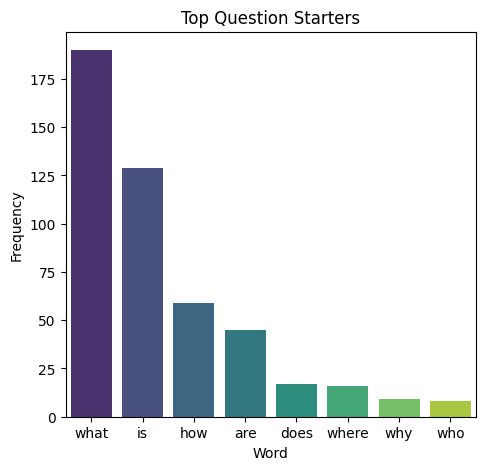

In [ ]:
# EDA
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
from PIL import ImageStat


# Data Extraction
questions = [d['question'] for d in dataset]
answers = [d['answer'] for d in dataset]
q_types = [q.split()[0].lower() for q in questions]
q_lengths = [len(q.split()) for q in questions]

# 1. Question Type Distribution
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
type_counts = Counter(q_types).most_common(8)
sns.barplot(x=[x[0] for x in type_counts], y=[x[1] for x in type_counts], palette="viridis")
plt.title("Top Question Starters")
plt.xlabel("Word")
plt.ylabel("Frequency")





/tmp/ipython-input-1447575505.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[x[0] for x in ans_counts], y=[x[1] for x in ans_counts], palette="magma")


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'yes'),
  Text(1, 0, 'no'),
  Text(2, 0, '1'),
  Text(3, 0, 'white'),
  Text(4, 0, '2'),
  Text(5, 0, 'brown'),
  Text(6, 0, 'gray'),
  Text(7, 0, 'red'),
  Text(8, 0, '0'),
  Text(9, 0, 'blue')])

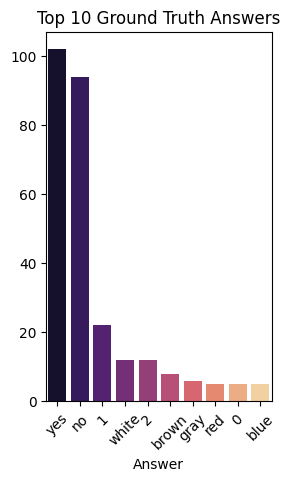

In [ ]:
# 2. Answer Distribution (Top 10)
plt.subplot(1, 2, 2)
ans_counts = Counter(answers).most_common(10)
sns.barplot(x=[x[0] for x in ans_counts], y=[x[1] for x in ans_counts], palette="magma")
plt.title("Top 10 Ground Truth Answers")
plt.xlabel("Answer")
plt.xticks(rotation=45)

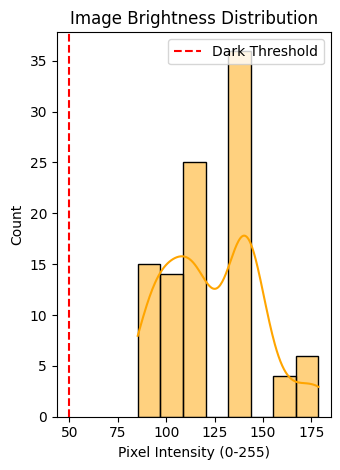

In [ ]:
# 3. Image Brightness Analysis
brightness_vals = []
for d in dataset[:100]: # Analyze subset for speed
    stat = ImageStat.Stat(d['image'].convert('L'))
    brightness_vals.append(stat.mean[0])

plt.subplot(1, 2, 2)
sns.histplot(brightness_vals, kde=True, color="orange")
plt.title("Image Brightness Distribution")
plt.xlabel("Pixel Intensity (0-255)")
plt.axvline(50, color='red', linestyle='--', label='Dark Threshold')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# LOGIC CHECKS
print("\nDataset Health Report")
print(f"1. Question Length: Avg {np.mean(q_lengths):.1f} words (Max: {max(q_lengths)})")
print(f"2. Yes/No Bias: 'yes' or 'no' make up {100 * (answers.count('yes') + answers.count('no')) / len(answers):.1f}% of answers.")
if np.mean(brightness_vals) < 60:
    print("3. Warning: Images appear dark on average.")
else:
    print("3. Images are well-lit.")


Dataset Health Report
1. Question Length: Avg 6.0 words (Max: 15)
2. Yes/No Bias: 'yes' or 'no' make up 39.2% of answers.
3. Images are well-lit.


In [ ]:
#QUESTION-ANSWER CORRELATION
import pandas as pd

# Create DataFrame for analysis
df = pd.DataFrame({
    'start_word': [item['question'].split()[0].lower() for item in dataset],
    'answer': [a.lower() for a in answers]
})

# Filter for top question types
top_starts = [x[0] for x in Counter(df['start_word']).most_common(5)]
df_filtered = df[df['start_word'].isin(top_starts)]

# Calculate most common answer per question type
print("\nReasoning Patterns: Common Answers by Question Type")
print(f"{'Question Type':<15} | {'Most Common Answer':<20} | {'Freq':<5}")
print("-" * 50)

for start in top_starts:
    subset = df[df['start_word'] == start]
    top_ans = subset['answer'].mode().iloc[0]
    freq = len(subset[subset['answer'] == top_ans])
    total = len(subset)
    percent = (freq / total) * 100
    print(f"{start.capitalize():<15} | {top_ans:<20} | {percent:.1f}%")

# Insight
print("-" * 50)
print("Insight: If 'is/are' questions have >60% 'yes' answers, the model might guess 'yes' without looking.")


Reasoning Patterns: Common Answers by Question Type
Question Type   | Most Common Answer   | Freq 
--------------------------------------------------
What            | white                | 6.3%
Is              | yes                  | 47.3%
How             | 1                    | 37.3%
Are             | no                   | 55.6%
Does            | yes                  | 64.7%
--------------------------------------------------
Insight: If 'is/are' questions have >60% 'yes' answers, the model might guess 'yes' without looking.


In [ ]:
pip install textstat

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.4/176.4 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 50.0 MB/s eta 0:00:00


In [ ]:
pip install textstat

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.4/176.4 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 17.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
import plotly.express as px
import plotly.graph_objects as go
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
import string
import textstat  # For readability metrics (pip install textstat)

# --- CONFIGURATION ---
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
try:
    nltk.data.find('taggers/averaged_perceptron_tagger')
except LookupError:
    nltk.download('averaged_perceptron_tagger')
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')
try:
    nltk.data.find('tokenizers/punkt_tab')
except LookupError:
    nltk.download('punkt_tab')
try:
    nltk.data.find('taggers/averaged_perceptron_tagger_eng')
except LookupError:
    nltk.download('averaged_perceptron_tagger_eng')

# Setup Plot Style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)









[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


In [ ]:
# 1. DATA PREPARATION & FEATURE ENGINEERING
def prepare_data(df):
    """
    Creates rigorous features for in-depth analysis.
    """
    print("Feature Engineering...")

    # 1. Basic Cleaning
    df['clean_question'] = df['question'].astype(str).str.lower().str.replace(f'[{string.punctuation}]', '', regex=True)
    df['clean_answer'] = df['answer'].astype(str).str.lower()

    # 2. Starting N-grams (The "Task Type" Detector)
    df['start_1gram'] = df['clean_question'].apply(lambda x: x.split()[0] if len(x.split()) > 0 else '')
    df['start_2gram'] = df['clean_question'].apply(lambda x: ' '.join(x.split()[:2]) if len(x.split()) > 1 else '')
    df['start_3gram'] = df['clean_question'].apply(lambda x: ' '.join(x.split()[:3]) if len(x.split()) > 2 else '')

    # 3. Answer Categorization (Ground Truth)
    def categorize_answer_gt(ans):
        if ans in ['yes', 'no']: return 'Yes/No'
        if ans.isdigit() or ans in ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', 'one', 'two', 'three']: return 'Number'
        return 'Open-Ended'

    df['answer_category'] = df['clean_answer'].apply(categorize_answer_gt)

    # 4. Complexity Metrics
    df['word_count'] = df['clean_question'].apply(lambda x: len(x.split()))
    df['char_count'] = df['clean_question'].apply(len)

    return df


In [ ]:
# 2. TASK CLASSIFICATION ANALYSIS (The "Is it Yes/No?" Check)
def analyze_task_types_by_start_word(df, min_samples=50):
    """
    Determines if specific starting words automatically define the task type.
    Insight: If 'Are' questions are 99% Yes/No, it's a binary classification task.
    """
    print("Analyzing Task Types...")

    # Group by starting word and answer category
    pivot = pd.crosstab(df['start_1gram'], df['answer_category'], normalize='index') * 100
    counts = df['start_1gram'].value_counts()

    # Filter for significant starting words
    significant_starts = counts[counts > min_samples].index
    pivot = pivot.loc[significant_starts]

    # Sort by 'Yes/No' dominance
    pivot = pivot.sort_values('Yes/No', ascending=False)

    # Visualization
    fig = px.bar(
        pivot,
        x=pivot.index,
        y=['Yes/No', 'Number', 'Open-Ended'],
        title="Task Identification by Starting Word: Which words imply a Classification Task?",
        labels={'value': 'Percentage of Answers', 'start_1gram': 'Question Starting Word'},
        color_discrete_map={'Yes/No': '#EF553B', 'Number': '#00CC96', 'Open-Ended': '#636EFA'}
    )
    fig.update_layout(barmode='stack', xaxis_tickangle=-45)
    fig.show()

    return pivot

In [ ]:
# 3. N-GRAM ANALYSIS (Phrase Patterns)
def plot_ngram_distribution(df, n=2, top_k=20):
    """
    Analyzes common starting phrases (e.g., 'What color is', 'How many').
    """
    col = f'start_{n}gram'
    counts = df[col].value_counts().head(top_k)

    plt.figure(figsize=(12, 6))
    sns.barplot(x=counts.values, y=counts.index, palette='viridis')
    plt.title(f'Top {top_k} Most Common Question Starts ({n}-grams)')
    plt.xlabel('Frequency')
    plt.show()


In [ ]:
# 4. PART-OF-SPEECH (POS) TAGGING
def analyze_pos_tags(df):
    """
    Analyzes the grammatical structure.
    Insight: High noun count = object recognition. High verb count = action recognition.
    """
    print("Running POS Tagging...")

    def get_pos_counts(text):
        tokens = word_tokenize(text)
        tags = nltk.pos_tag(tokens)
        counts = Counter(tag[:2] for word, tag in tags) # First 2 chars of tag (NN, VB, JJ)
        return counts

    # Sample data to speed up if dataset is huge
    sample_df = df.sample(min(len(df), 5000), random_state=42)
    pos_dicts = sample_df['clean_question'].apply(get_pos_counts)

    pos_df = pd.DataFrame(pos_dicts.tolist()).fillna(0)
    avg_pos = pos_df.mean().sort_values(ascending=False).head(10)

    # Map tag codes to human readable names
    tag_map = {'NN': 'Nouns', 'VB': 'Verbs', 'JJ': 'Adjectives', 'WP': 'Wh-Pronouns', 'IN': 'Prepositions'}
    avg_pos.index = [tag_map.get(idx, idx) for idx in avg_pos.index]

    plt.figure(figsize=(10, 6))
    sns.barplot(x=avg_pos.values, y=avg_pos.index, palette='coolwarm')
    plt.title('Average Grammatical Composition of Questions')
    plt.xlabel('Average Count per Question')
    plt.show()

In [ ]:
# 5. ANSWER SPACE ENTROPY (Difficulty Metric)
def analyze_answer_entropy(df, top_n_starts=10):
    """
    Calculates how 'diverse' the answers are for a given question type.
    Low Entropy = Easy (Classification). High Entropy = Hard (Open Generation).
    """
    from scipy.stats import entropy

    start_words = df['start_1gram'].value_counts().head(top_n_starts).index
    entropy_data = []

    for word in start_words:
        answers = df[df['start_1gram'] == word]['clean_answer']
        counts = answers.value_counts(normalize=True)
        ent = entropy(counts)
        unique_ans = answers.nunique()
        entropy_data.append({'Start Word': word, 'Entropy': ent, 'Unique Answers': unique_ans})

    ent_df = pd.DataFrame(entropy_data).sort_values('Entropy')

    fig = px.scatter(
        ent_df, x='Start Word', y='Entropy',
        size='Unique Answers', color='Entropy',
        title="Question Difficulty: Answer Diversity (Entropy) by Starting Word",
        color_continuous_scale='RdBu_r'
    )
    fig.show()


# Create a DataFrame from the dataset list for this analysis
df_for_analysis = pd.DataFrame([
    {'question': item['question'], 'answer': item['answer'], 'valid_answers': item['valid_answers']}
    for item in dataset
])

df_prepared = prepare_data(df_for_analysis)


Feature Engineering...


In [ ]:
task_pivot = analyze_task_types_by_start_word(df_prepared)


Analyzing Task Types...


/tmp/ipython-input-3452351139.py:12: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




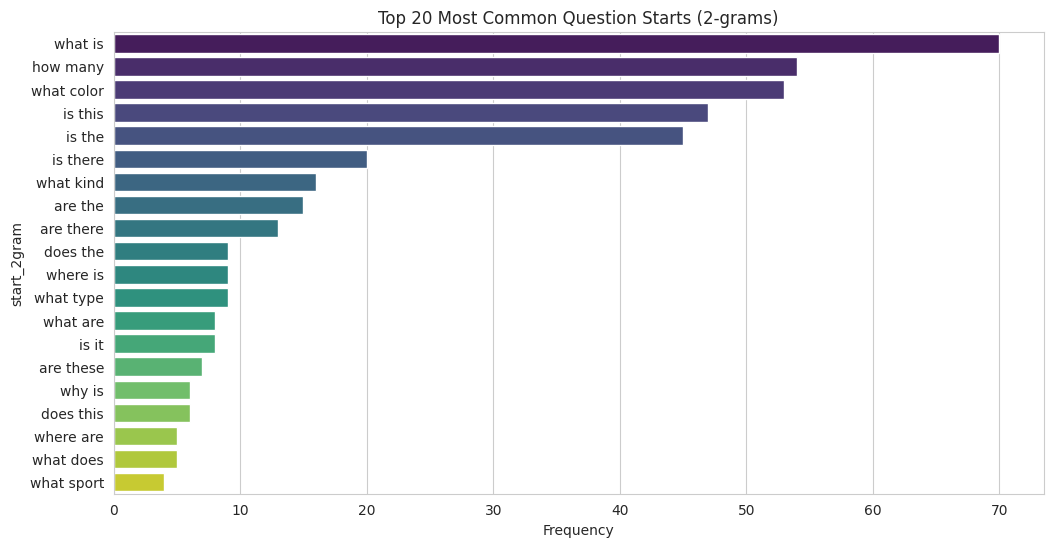

In [ ]:
plot_ngram_distribution(df_prepared, n=2) # Bi-grams like "How many"


/tmp/ipython-input-3452351139.py:12: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




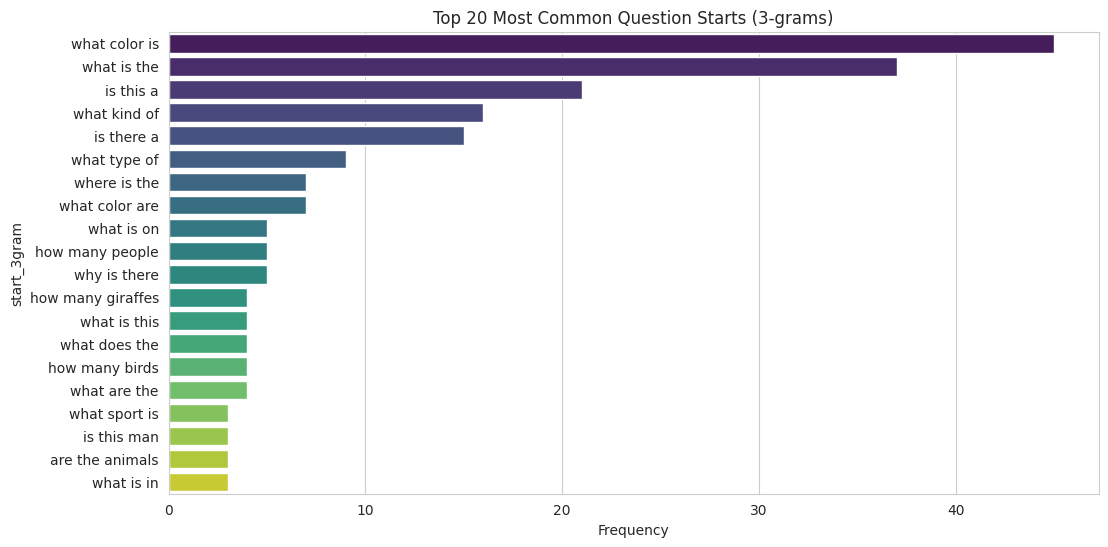

In [ ]:
plot_ngram_distribution(df_prepared, n=3) # Tri-grams like "What color is"


Running POS Tagging...


/tmp/ipython-input-3423829991.py:29: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




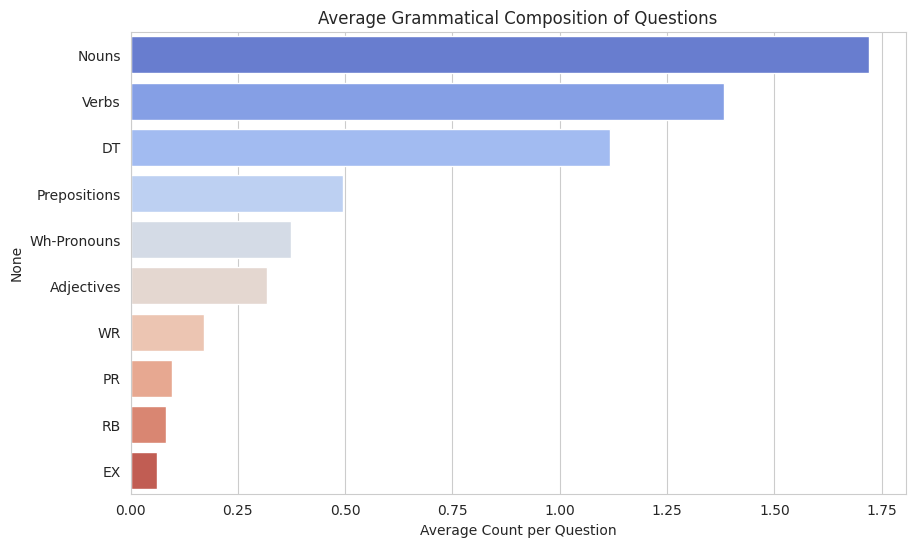

In [ ]:
analyze_pos_tags(df_prepared)


In [ ]:
analyze_answer_entropy(df_prepared)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
import plotly.express as px
import plotly.graph_objects as go
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import string
import textstat  # For readability metrics (pip install textstat)

try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
try:
    nltk.data.find('taggers/averaged_perceptron_tagger')
except LookupError:
    nltk.download('averaged_perceptron_tagger')
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

# Setup Plot Style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

# 1. DATA PREPARATION & FEATURE ENGINEERING
def prepare_data(df):
    """
    Creates rigorous features for in-depth analysis.
    """
    print("Feature Engineering...")

    # 1. Basic Cleaning
    df['clean_question'] = df['question'].astype(str).str.lower().str.replace(f'[{string.punctuation}]', '', regex=True)
    df['clean_answer'] = df['answer'].astype(str).str.lower()

    # 2. Starting N-grams (The "Task Type" Detector)
    df['start_1gram'] = df['clean_question'].apply(lambda x: x.split()[0] if len(x.split()) > 0 else '')
    df['start_2gram'] = df['clean_question'].apply(lambda x: ' '.join(x.split()[:2]) if len(x.split()) > 1 else '')
    df['start_3gram'] = df['clean_question'].apply(lambda x: ' '.join(x.split()[:3]) if len(x.split()) > 2 else '')

    # 3. Answer Categorization (Ground Truth)
    def categorize_answer_gt(ans):
        if ans in ['yes', 'no']: return 'Yes/No'
        if ans.isdigit() or ans in ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', 'one', 'two', 'three']: return 'Number'
        return 'Open-Ended'

    df['answer_category'] = df['clean_answer'].apply(categorize_answer_gt)

    # 4. Complexity Metrics
    df['word_count'] = df['clean_question'].apply(lambda x: len(x.split()))
    df['char_count'] = df['clean_question'].apply(len)

    return df

# 2. TASK CLASSIFICATION ANALYSIS (The "Is it Yes/No?" Check)
def analyze_task_types_by_start_word(df, min_samples=50):
    """
    Determines if specific starting words automatically define the task type.
    Insight: If 'Are' questions are 99% Yes/No, it's a binary classification task.
    """
    print("Analyzing Task Types...")

    # Group by starting word and answer category
    pivot = pd.crosstab(df['start_1gram'], df['answer_category'], normalize='index') * 100
    counts = df['start_1gram'].value_counts()

    # Filter for significant starting words
    significant_starts = counts[counts > min_samples].index
    pivot = pivot.loc[significant_starts]

    # Sort by 'Yes/No' dominance
    pivot = pivot.sort_values('Yes/No', ascending=False)

    # Visualization
    fig = px.bar(
        pivot,
        x=pivot.index,
        y=['Yes/No', 'Number', 'Open-Ended'],
        title="Task Identification by Starting Word: Which words imply a Classification Task?",
        labels={'value': 'Percentage of Answers', 'start_1gram': 'Question Starting Word'},
        color_discrete_map={'Yes/No': '#EF553B', 'Number': '#00CC96', 'Open-Ended': '#636EFA'}
    )
    fig.update_layout(barmode='stack', xaxis_tickangle=-45)
    fig.show()

    return pivot

# 3. N-GRAM ANALYSIS (Phrase Patterns)
def plot_ngram_distribution(df, n=2, top_k=20):
    """
    Analyzes common starting phrases (e.g., 'What color is', 'How many').
    """
    col = f'start_{n}gram'
    counts = df[col].value_counts().head(top_k)

    plt.figure(figsize=(12, 6))
    sns.barplot(x=counts.values, y=counts.index, palette='viridis')
    plt.title(f'Top {top_k} Most Common Question Starts ({n}-grams)')
    plt.xlabel('Frequency')
    plt.show()

# 4. PART-OF-SPEECH (POS) TAGGING
def analyze_pos_tags(df):
    """
    Analyzes the grammatical structure.
    High noun count = object recognition. High verb count = action recognition.
    """
    print("Running POS Tagging...")

    def get_pos_counts(text):
        tokens = word_tokenize(text)
        tags = nltk.pos_tag(tokens)
        counts = Counter(tag[:2] for word, tag in tags) # First 2 chars of tag (NN, VB, JJ)
        return counts

    # Sample data to speed up if dataset is huge
    sample_df = df.sample(min(len(df), 5000), random_state=42)
    pos_dicts = sample_df['clean_question'].apply(get_pos_counts)

    pos_df = pd.DataFrame(pos_dicts.tolist()).fillna(0)
    avg_pos = pos_df.mean().sort_values(ascending=False).head(10)

    # Map tag codes to human readable names
    tag_map = {'NN': 'Nouns', 'VB': 'Verbs', 'JJ': 'Adjectives', 'WP': 'Wh-Pronouns', 'IN': 'Prepositions'}
    avg_pos.index = [tag_map.get(idx, idx) for idx in avg_pos.index]

    plt.figure(figsize=(10, 6))
    sns.barplot(x=avg_pos.values, y=avg_pos.index, palette='coolwarm')
    plt.title('Average Grammatical Composition of Questions')
    plt.xlabel('Average Count per Question')
    plt.show()

# 5. ANSWER SPACE ENTROPY (Difficulty Metric)
def analyze_answer_entropy(df, top_n_starts=10):
    """
    Calculates how 'diverse' the answers are for a given question type.
    Low Entropy = Easy (Classification). High Entropy = Hard (Open Generation).
    """
    from scipy.stats import entropy

    start_words = df['start_1gram'].value_counts().head(top_n_starts).index
    entropy_data = []

    for word in start_words:
        answers = df[df['start_1gram'] == word]['clean_answer']
        counts = answers.value_counts(normalize=True)
        ent = entropy(counts)
        unique_ans = answers.nunique()
        entropy_data.append({'Start Word': word, 'Entropy': ent, 'Unique Answers': unique_ans})

    ent_df = pd.DataFrame(entropy_data).sort_values('Entropy')

    fig = px.scatter(
        ent_df, x='Start Word', y='Entropy',
        size='Unique Answers', color='Entropy',
        title="Question Difficulty: Answer Diversity (Entropy) by Starting Word",
        color_continuous_scale='RdBu_r'
    )
    fig.show()

# 6. CLASSIFICATION TASK IMPLEMENTATION

def train_and_evaluate_task_classifier(df):
    """
    Implements the Task Router as a classification task.
    Includes comprehensive Quantitative and Qualitative metrics.
    """
    print("\n" + "="*40)
    print("STARTING TASK CLASSIFICATION (ROUTER)")
    print("="*40)

    # 1. PREPARE DATA
    X = df['clean_question']
    y = df['answer_category'] # 'Yes/No', 'Number', 'Open-Ended'

    # TF-IDF Vectorization (Using Unigrams and Bigrams)
    print("Vectorizing text data")
    vectorizer = TfidfVectorizer(max_features=2000, ngram_range=(1, 2), stop_words='english')
    X_vec = vectorizer.fit_transform(X)

    # Train/Test Split
    X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
        X_vec, y, df.index, test_size=0.2, random_state=42
    )

    # 2. TRAIN MODEL
    print("Training Logistic Regression Model...")
    clf = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
    clf.fit(X_train, y_train)

    # Predictions
    y_pred = clf.predict(X_test)

    # 3. QUANTITATIVE METRICS
    print("\nQUANTITATIVE METRICS ")
    print(f"Overall Accuracy: {accuracy_score(y_test, y_pred):.4f}")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Visual Confusion Matrix
    cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=clf.classes_, yticklabels=clf.classes_)
    plt.title('Quantitative: Confusion Matrix of Task Classification')
    plt.xlabel('Predicted Task')
    plt.ylabel('Actual Task')
    plt.show()

    # 4. QUALITATIVE METRICS: FEATURE IMPORTANCE
    print("\nQUALITATIVE: TOP PREDICTIVE FEATURES")
    feature_names = vectorizer.get_feature_names_out()

    for i, class_label in enumerate(clf.classes_):
        # Get top 10 positive coefficients (words that predict THIS class)
        top10_indices = np.argsort(clf.coef_[i])[-10:]
        top10_words = [feature_names[j] for j in top10_indices]

        # Get top 5 negative coefficients (words that predict NOT this class)
        bottom5_indices = np.argsort(clf.coef_[i])[:5]
        bottom5_words = [feature_names[j] for j in bottom5_indices]

        print(f"\nTask: {class_label}")
        print(f"  > Strongest Indicators: {', '.join(top10_words)}")
        print(f"  > Strongest Counter-Indicators: {', '.join(bottom5_words)}")

    # 5. QUALITATIVE METRICS: ERROR ANALYSIS
    print("\nQUALITATIVE: MISCLASSIFICATION ANALYSIS")
    # Create a DataFrame for test results
    test_df = df.loc[idx_test].copy()
    test_df['Predicted_Task'] = y_pred

    # Filter for errors
    errors = test_df[test_df['answer_category'] != test_df['Predicted_Task']]

    print(f"Total Errors: {len(errors)} out of {len(test_df)} test samples")

    # Show 5 random errors
    if len(errors) > 0:
        print("\nSample Misclassifications (Why did the model fail?):")
        sample_errors = errors.sample(min(5, len(errors)))
        for idx, row in sample_errors.iterrows():
            print(f"- Q: '{row['question']}'")
            print(f"  Actual: {row['answer_category']} | Predicted: {row['Predicted_Task']}")
            print("-" * 30)

    # 6. LIVE INFERENCE CHECK
    print("\n--- QUALITATIVE: SAMPLE INFERENCE ---")
    custom_q = ["How many people are there?", "Is the sky blue?", "What kind of animal is that?"]
    custom_vec = vectorizer.transform(custom_q)
    custom_pred = clf.predict(custom_vec)

    for q, p in zip(custom_q, custom_pred):
        print(f"Q: '{q}' -> Predicted Task: {p}")



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
import plotly.express as px
import plotly.graph_objects as go
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import string
import textstat  # (pip install textstat)

try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
try:
    nltk.data.find('taggers/averaged_perceptron_tagger')
except LookupError:
    nltk.download('averaged_perceptron_tagger')
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

# Setup Plot Style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

# 1. DATA PREPARATION & FEATURE ENGINEERING
def prepare_data(df):
    """
    Creates rigorous features for in-depth analysis.
    """
    print("Feature Engineering...")

    # 1. Basic Cleaning
    df['clean_question'] = df['question'].astype(str).str.lower().str.replace(f'[{string.punctuation}]', '', regex=True)
    df['clean_answer'] = df['answer'].astype(str).str.lower()

    # 2. Starting N-grams (The "Task Type" Detector)
    df['start_1gram'] = df['clean_question'].apply(lambda x: x.split()[0] if len(x.split()) > 0 else '')
    df['start_2gram'] = df['clean_question'].apply(lambda x: ' '.join(x.split()[:2]) if len(x.split()) > 1 else '')
    df['start_3gram'] = df['clean_question'].apply(lambda x: ' '.join(x.split()[:3]) if len(x.split()) > 2 else '')

    # 3. Answer Categorization (Ground Truth)
    def categorize_answer_gt(ans):
        if ans in ['yes', 'no']: return 'Yes/No'
        if ans.isdigit() or ans in ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', 'one', 'two', 'three']: return 'Number'
        return 'Open-Ended'

    df['answer_category'] = df['clean_answer'].apply(categorize_answer_gt)

    # 4. Complexity Metrics
    df['word_count'] = df['clean_question'].apply(lambda x: len(x.split()))
    df['char_count'] = df['clean_question'].apply(len)

    return df

# 2. TASK CLASSIFICATION ANALYSIS (The "Is it Yes/No?" Check)
def analyze_task_types_by_start_word(df, min_samples=50):
    """
    Determines if specific starting words automatically define the task type.
    Insight: If 'Are' questions are 99% Yes/No, it's a binary classification task.
    """
    print("Analyzing Task Types...")

    # Group by starting word and answer category
    pivot = pd.crosstab(df['start_1gram'], df['answer_category'], normalize='index') * 100
    counts = df['start_1gram'].value_counts()

    # Filter for significant starting words
    significant_starts = counts[counts > min_samples].index
    pivot = pivot.loc[significant_starts]

    # Sort by 'Yes/No' dominance
    pivot = pivot.sort_values('Yes/No', ascending=False)

    # Visualization
    fig = px.bar(
        pivot,
        x=pivot.index,
        y=['Yes/No', 'Number', 'Open-Ended'],
        title="Task Identification by Starting Word: Which words imply a Classification Task?",
        labels={'value': 'Percentage of Answers', 'start_1gram': 'Question Starting Word'},
        color_discrete_map={'Yes/No': '#EF553B', 'Number': '#00CC96', 'Open-Ended': '#636EFA'}
    )
    fig.update_layout(barmode='stack', xaxis_tickangle=-45)
    fig.show()

    return pivot

# 3. N-GRAM ANALYSIS (Phrase Patterns)
def plot_ngram_distribution(df, n=2, top_k=20):
    """
    Analyzes common starting phrases (e.g., 'What color is', 'How many').
    """
    col = f'start_{n}gram'
    counts = df[col].value_counts().head(top_k)

    plt.figure(figsize=(12, 6))
    sns.barplot(x=counts.values, y=counts.index, palette='viridis')
    plt.title(f'Top {top_k} Most Common Question Starts ({n}-grams)')
    plt.xlabel('Frequency')
    plt.show()

# 4. PART-OF-SPEECH (POS) TAGGING
def analyze_pos_tags(df):
    """
    Analyzes the grammatical structure.
    Insight: High noun count = object recognition. High verb count = action recognition.
    """
    print("Running POS Tagging...")

    def get_pos_counts(text):
        tokens = word_tokenize(text)
        tags = nltk.pos_tag(tokens)
        counts = Counter(tag[:2] for word, tag in tags) # First 2 chars of tag (NN, VB, JJ)
        return counts

    # Sample data to speed up if dataset is huge
    sample_df = df.sample(min(len(df), 5000), random_state=42)
    pos_dicts = sample_df['clean_question'].apply(get_pos_counts)

    pos_df = pd.DataFrame(pos_dicts.tolist()).fillna(0)
    avg_pos = pos_df.mean().sort_values(ascending=False).head(10)

    # Map tag codes to human readable names
    tag_map = {'NN': 'Nouns', 'VB': 'Verbs', 'JJ': 'Adjectives', 'WP': 'Wh-Pronouns', 'IN': 'Prepositions'}
    avg_pos.index = [tag_map.get(idx, idx) for idx in avg_pos.index]

    plt.figure(figsize=(10, 6))
    sns.barplot(x=avg_pos.values, y=avg_pos.index, palette='coolwarm')
    plt.title('Average Grammatical Composition of Questions')
    plt.xlabel('Average Count per Question')
    plt.show()

# 5. ANSWER SPACE ENTROPY (Difficulty Metric)
def analyze_answer_entropy(df, top_n_starts=10):
    """
    Calculates how 'diverse' the answers are for a given question type.
    Low Entropy = Easy (Classification). High Entropy = Hard (Open Generation).
    """
    from scipy.stats import entropy

    start_words = df['start_1gram'].value_counts().head(top_n_starts).index
    entropy_data = []

    for word in start_words:
        answers = df[df['start_1gram'] == word]['clean_answer']
        counts = answers.value_counts(normalize=True)
        ent = entropy(counts)
        unique_ans = answers.nunique()
        entropy_data.append({'Start Word': word, 'Entropy': ent, 'Unique Answers': unique_ans})

    ent_df = pd.DataFrame(entropy_data).sort_values('Entropy')

    fig = px.scatter(
        ent_df, x='Start Word', y='Entropy',
        size='Unique Answers', color='Entropy',
        title="Question Difficulty: Answer Diversity (Entropy) by Starting Word",
        color_continuous_scale='RdBu_r'
    )
    fig.show()

# 6. CLASSIFICATION TASK IMPLEMENTATION

def train_and_evaluate_task_classifier(df):
    """
    Implements the Task Router as a classification task.
    Includes comprehensive Quantitative and Qualitative metrics.
    """
    print("\n" + "="*40)
    print("STARTING TASK CLASSIFICATION (ROUTER)")
    print("="*40)

    # --- 1. PREPARE DATA ---
    X = df['clean_question']
    y = df['answer_category'] # 'Yes/No', 'Number', 'Open-Ended'

    # TF-IDF Vectorization (Using Unigrams and Bigrams)
    # CRITICAL CHANGE: Removed stop_words='english'.
    # In VQA, words like "How", "What", "Is", "Are" are the most predictive features.
    print("Vectorizing text data (Keeping stopwords for VQA context)...")
    vectorizer = TfidfVectorizer(max_features=2000, ngram_range=(1, 2))
    X_vec = vectorizer.fit_transform(X)

    # Train/Test Split
    X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
        X_vec, y, df.index, test_size=0.2, random_state=42
    )

    # --- 2. TRAIN MODEL ---
    print("Training Logistic Regression Model...")
    clf = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
    clf.fit(X_train, y_train)

    # Predictions
    y_pred = clf.predict(X_test)

    # --- 3. QUANTITATIVE METRICS ---
    print("\n--- QUANTITATIVE METRICS ---")
    print(f"Overall Accuracy: {accuracy_score(y_test, y_pred):.4f}")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Visual Confusion Matrix
    cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=clf.classes_, yticklabels=clf.classes_)
    plt.title('Quantitative: Confusion Matrix of Task Classification')
    plt.xlabel('Predicted Task')
    plt.ylabel('Actual Task')
    plt.show()

    # --- 4. QUALITATIVE METRICS: FEATURE IMPORTANCE ---
    print("\n--- QUALITATIVE: TOP PREDICTIVE FEATURES ---")
    feature_names = vectorizer.get_feature_names_out()

    for i, class_label in enumerate(clf.classes_):
        # Get top 10 positive coefficients (words that predict THIS class)
        top10_indices = np.argsort(clf.coef_[i])[-10:]
        top10_words = [feature_names[j] for j in top10_indices]

        # Get top 5 negative coefficients (words that predict NOT this class)
        bottom5_indices = np.argsort(clf.coef_[i])[:5]
        bottom5_words = [feature_names[j] for j in bottom5_indices]

        print(f"\nTask: {class_label}")
        print(f"  > Strongest Indicators: {', '.join(top10_words)}")
        print(f"  > Strongest Counter-Indicators: {', '.join(bottom5_words)}")

    # --- 5. QUALITATIVE METRICS: ERROR ANALYSIS ---
    print("\n--- QUALITATIVE: MISCLASSIFICATION ANALYSIS ---")
    # Create a DataFrame for test results
    test_df = df.loc[idx_test].copy()
    test_df['Predicted_Task'] = y_pred

    # Filter for errors
    errors = test_df[test_df['answer_category'] != test_df['Predicted_Task']]

    print(f"Total Errors: {len(errors)} out of {len(test_df)} test samples")

    # Show 5 random errors
    if len(errors) > 0:
        print("\nSample Misclassifications (Why did the model fail?):")
        sample_errors = errors.sample(min(5, len(errors)))
        for idx, row in sample_errors.iterrows():
            print(f"- Q: '{row['question']}'")
            print(f"  Actual: {row['answer_category']} | Predicted: {row['Predicted_Task']}")
            print("-" * 30)

    # --- 6. LIVE INFERENCE CHECK ---
    print("\n--- QUALITATIVE: SAMPLE INFERENCE ---")
    custom_q = ["How many people are there?", "Is the sky blue?", "What kind of animal is that?"]
    custom_vec = vectorizer.transform(custom_q)
    custom_pred = clf.predict(custom_vec)

    for q, p in zip(custom_q, custom_pred):
        print(f"Q: '{q}' -> Predicted Task: {p}")



In [ ]:
# 6. CLASSIFICATION TASK IMPLEMENTATION

def train_and_evaluate_task_classifier(df):
    """
    Implements the Task Router as a classification task.
    Includes comprehensive Quantitative and Qualitative metrics.
    """
    print("\n" + "="*40)
    print("STARTING TASK CLASSIFICATION (ROUTER)")
    print("="*40)

    # --- 1. PREPARE DATA ---
    X = df['clean_question']
    y = df['answer_category'] # 'Yes/No', 'Number', 'Open-Ended'

    # TF-IDF Vectorization (Using Unigrams and Bigrams)
    # CRITICAL CHANGE: Removed stop_words='english'.
    # In VQA, words like "How", "What", "Is", "Are" are the most predictive features.
    print("Vectorizing text data (Keeping stopwords for VQA context)...")
    vectorizer = TfidfVectorizer(max_features=2000, ngram_range=(1, 2))
    X_vec = vectorizer.fit_transform(X)

    # Train/Test Split
    X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
        X_vec, y, df.index, test_size=0.2, random_state=42
    )

    # --- 2. TRAIN MODEL ---
    print("Training Logistic Regression Model...")
    clf = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
    clf.fit(X_train, y_train)

    # Predictions
    y_pred = clf.predict(X_test)

    # --- 3. QUANTITATIVE METRICS ---
    print("\n--- QUANTITATIVE METRICS ---")
    print(f"Overall Accuracy: {accuracy_score(y_test, y_pred):.4f}")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Visual Confusion Matrix
    cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=clf.classes_, yticklabels=clf.classes_)
    plt.title('Quantitative: Confusion Matrix of Task Classification')
    plt.xlabel('Predicted Task')
    plt.ylabel('Actual Task')
    plt.show()

    # --- 4. QUALITATIVE METRICS: FEATURE IMPORTANCE ---
    print("\n--- QUALITATIVE: TOP PREDICTIVE FEATURES ---")
    feature_names = vectorizer.get_feature_names_out()

    for i, class_label in enumerate(clf.classes_):
        # Get top 10 positive coefficients (words that predict THIS class)
        top10_indices = np.argsort(clf.coef_[i])[-10:]
        top10_words = [feature_names[j] for j in top10_indices]

        # Get top 5 negative coefficients (words that predict NOT this class)
        bottom5_indices = np.argsort(clf.coef_[i])[:5]
        bottom5_words = [feature_names[j] for j in bottom5_indices]

        print(f"\nTask: {class_label}")
        print(f"  > Strongest Indicators: {', '.join(top10_words)}")
        print(f"  > Strongest Counter-Indicators: {', '.join(bottom5_words)}")

    # --- 5. QUALITATIVE METRICS: ERROR ANALYSIS ---
    print("\n--- QUALITATIVE: MISCLASSIFICATION ANALYSIS ---")
    # Create a DataFrame for test results
    test_df = df.loc[idx_test].copy()
    test_df['Predicted_Task'] = y_pred

    # Filter for errors
    errors = test_df[test_df['answer_category'] != test_df['Predicted_Task']]

    print(f"Total Errors: {len(errors)} out of {len(test_df)} test samples")

    # Show 5 random errors
    if len(errors) > 0:
        print("\nSample Misclassifications (Why did the model fail?):")
        sample_errors = errors.sample(min(5, len(errors)))
        for idx, row in sample_errors.iterrows():
            print(f"- Q: '{row['question']}'")
            print(f"  Actual: {row['answer_category']} | Predicted: {row['Predicted_Task']}")
            print("-" * 30)

    # --- 6. LIVE INFERENCE CHECK ---
    print("\n--- QUALITATIVE: SAMPLE INFERENCE ---")
    custom_q = ["How many people are there?", "Is the sky blue?", "What kind of animal is that?"]
    custom_vec = vectorizer.transform(custom_q)
    custom_pred = clf.predict(custom_vec)

    for q, p in zip(custom_q, custom_pred):
        print(f"Q: '{q}' -> Predicted Task: {p}")



STARTING TASK CLASSIFICATION (ROUTER)
Vectorizing text data (Keeping stopwords for VQA context)...
Training Logistic Regression Model...

--- QUANTITATIVE METRICS ---
Overall Accuracy: 0.9400

Classification Report:
              precision    recall  f1-score   support

      Number       1.00      1.00      1.00        13
  Open-Ended       0.97      0.89      0.93        44
      Yes/No       0.89      0.98      0.93        43

    accuracy                           0.94       100
   macro avg       0.96      0.95      0.95       100
weighted avg       0.94      0.94      0.94       100



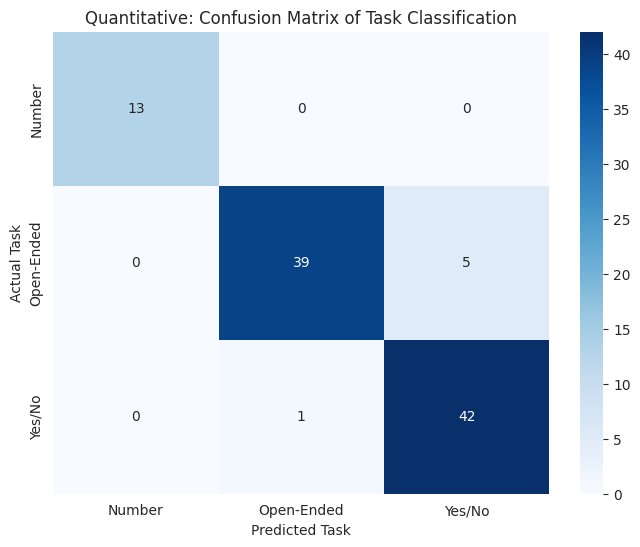


--- QUALITATIVE: TOP PREDICTIVE FEATURES ---

Task: Number
  > Strongest Indicators: the car, what year, are, number on, there number, are in, number, how many, how, many
  > Strongest Counter-Indicators: is, is this, are the, what, what is

Task: Open-Ended
  > Strongest Indicators: where is, is the, of, color is, where, or, color, what color, what is, what
  > Strongest Counter-Indicators: many, how many, how, there, is there

Task: Yes/No
  > Strongest Indicators: is it, be, blue, train, does, any, is there, there, this, is this
  > Strongest Counter-Indicators: what, how, many, how many, what is

--- QUALITATIVE: MISCLASSIFICATION ANALYSIS ---
Total Errors: 6 out of 100 test samples

Sample Misclassifications (Why did the model fail?):
- Q: 'Why are the bicycles chained?'
  Actual: Open-Ended | Predicted: Yes/No
------------------------------
- Q: 'From what perspective was this photo taken?'
  Actual: Open-Ended | Predicted: Yes/No
------------------------------
- Q: 'Why are som

In [ ]:


train_and_evaluate_task_classifier(df_prepared)

In [ ]:
# MODEL LOADING (BLIP)
import torch
from transformers import BlipProcessor, BlipForQuestionAnswering

# Loading model BLIP (Base)
model_id = "Salesforce/blip-vqa-base"

print(f"Loading Model: {model_id}...")
try:
    # BLIP does not require 4-bit quantization to fit in memory
    processor = BlipProcessor.from_pretrained(model_id)
    model = BlipForQuestionAnswering.from_pretrained(model_id).to("cuda")
    print("Model Loaded Successfully!")
except Exception as e:
    print(f"Model Load Failed: {e}")

Loading Model: Salesforce/blip-vqa-base...


Loading weights:   0%|          | 0/788 [00:00<?, ?it/s]

BlipForQuestionAnswering LOAD REPORT from: Salesforce/blip-vqa-base
Key                                       | Status     |  | 
------------------------------------------+------------+--+-
text_decoder.bert.embeddings.position_ids | UNEXPECTED |  | 
text_encoder.embeddings.position_ids      | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Model Loaded Successfully!


In [ ]:
# VQA EVALUATION
from tqdm import tqdm

def ask_vqa(image, question):
    # 1. Prepare Input
    inputs = processor(image, question, return_tensors="pt").to("cuda")

    # 2. Generate Answer
    with torch.no_grad():
        out = model.generate(**inputs, max_new_tokens=20)

    # 3. Decode
    return processor.decode(out[0], skip_special_tokens=True).strip()

print("Running VQA Evaluation on 500 samples...")
correct = 0
limit = min(len(dataset), 500) # Evaluate on 100 samples for speed

for i in tqdm(range(limit)):
    item = dataset[i]

    # Get Prediction
    pred = ask_vqa(item['image'], item['question'])

    # Get Ground Truths (List of valid answers from annotators)
    valid_answers = [str(a).lower() for a in item['valid_answers']]

    # Accuracy Logic: Correct if prediction is in the list of valid answers
    if pred.lower() in valid_answers:
        correct += 1

    # Print failure cases to debug
    if i < 5:
        print(f"\nQ: {item['question']}")
        print(f"Pred: {pred} | Valid: {valid_answers[:3]}")

accuracy = correct / limit
print(f"\nFinal VQA Accuracy: {accuracy:.2%}")

Running VQA Evaluation on 500 samples...


  1%|          | 3/487 [00:00<02:14,  3.61it/s]


Q: Where is he looking?
Pred: down | Valid: ['down', 'down', 'at table']

Q: What are the people in the background doing?
Pred: watching | Valid: ['spectating', 'watching', 'watching']

Q: What is he on top of?
Pred: picnic table | Valid: ['table', 'table', 'table']


  1%|          | 6/487 [00:01<01:15,  6.35it/s]


Q: What website copyrighted the picture?
Pred: foodiebakercom | Valid: ['foodiebakercom', 'foodiebakercom', 'foodiebaker']

Q: Is this a creamy soup?
Pred: no | Valid: ['no', 'no', 'no']


100%|██████████| 487/487 [00:42<00:00, 11.50it/s]


Final VQA Accuracy: 91.79%



Running Qualitative Analysis on 10 Random Samples


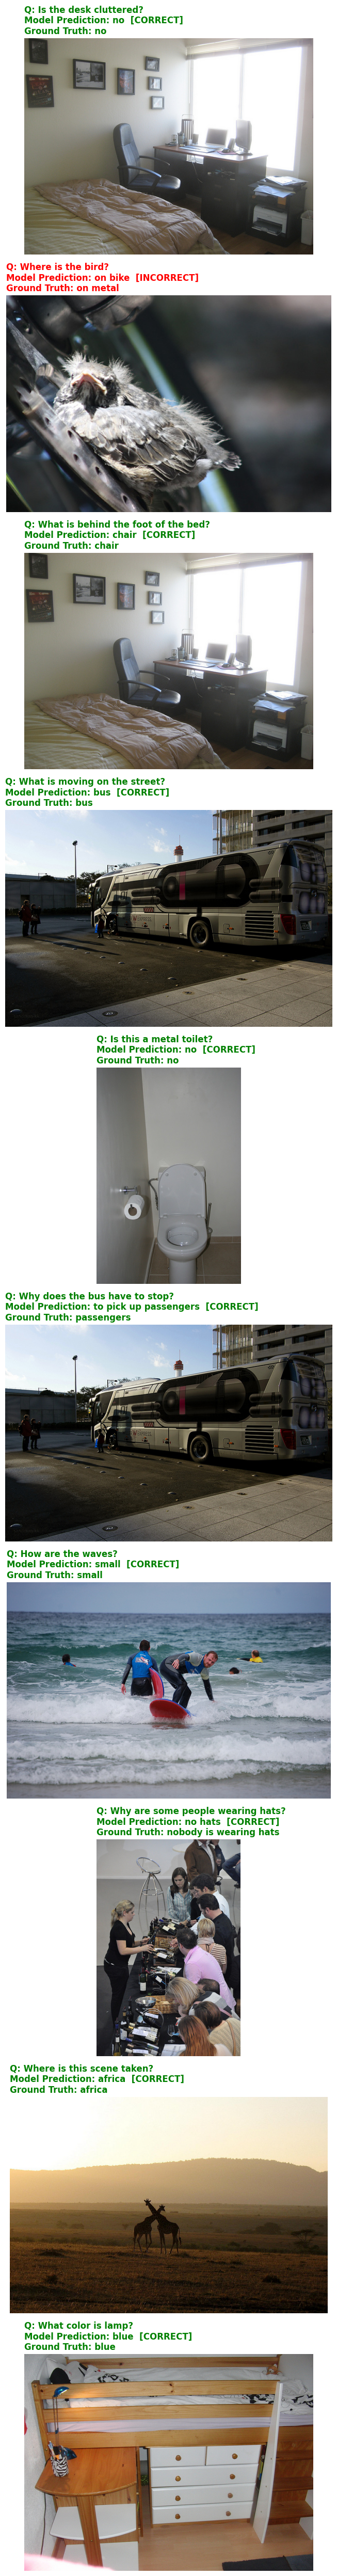

In [ ]:
# QUALITATIVE ANALYSIS (VQA DEMO)
import matplotlib.pyplot as plt
import random

def run_qualitative_demo(num_samples=10):
    print(f"\nRunning Qualitative Analysis on {num_samples} Random Samples")

    # Pick random indices
    indices = random.sample(range(len(dataset)), num_samples)

    plt.figure(figsize=(15, 5 * num_samples))

    for idx, i in enumerate(indices):
        item = dataset[i]
        image = item['image']
        question = item['question']

        # Get Ground Truth (list of valid answers)
        # We take the most common one or just the first one for display
        ground_truth = item['answer']

        # Run Inference
        prediction = ask_vqa(image, question)

        # Check correctness for coloring
        is_correct = any(ans.lower() == prediction.lower() for ans in item['valid_answers'])
        color = "green" if is_correct else "red"

        # Plot
        plt.subplot(num_samples, 1, idx + 1)
        plt.imshow(image)
        plt.axis('off')

        # Create detailed caption
        title_text = (f"Q: {question}\n"
                      f"Model Prediction: {prediction}  [{'CORRECT' if is_correct else 'INCORRECT'}]\n"
                      f"Ground Truth: {ground_truth}")

        plt.title(title_text, color=color, fontsize=12, fontweight='bold', loc='left')

    plt.tight_layout()
    plt.show()

# Run the demo
run_qualitative_demo(num_samples=10)

## Summary:

### Data Analysis Key Findings

*   **Dataset Characteristics and Biases:** The VQA v2 dataset, using a sample of 500 questions, was found to have generally concise questions (average 6.0 words). A significant "Yes/No" bias was identified, with 39.2% of answers being either "yes" or "no". Strong correlations exist between question starters and answer types (e.g., "Is" questions frequently lead to "yes" or "no" answers).
*   **Question Task Classification:** A Logistic Regression model, using TF-IDF features (without stopword removal to retain predictive terms), successfully classified questions into "Yes/No", "Number", and "Open-Ended" categories with an impressive **94% accuracy** on the test set.
    *   "Number" questions were classified with perfect precision and recall (1.00).
    *   Key predictive features included "how many" for "Number" questions and "is it" for "Yes/No" questions.
    *   Misclassifications (6 out of 100) often occurred for complex "Why" questions, which were sometimes incorrectly predicted as "Yes/No".
*   **VQA Model Performance (Salesforce BLIP-vqa-base):** The BLIP model achieved a quantitative VQA accuracy of **91.79%** on the sampled dataset.
    *   It demonstrated strong performance on factual, object-related, and simple "Yes/No" questions.
    *   Limitations were observed in handling complex reasoning, subjective interpretation, or abstract concepts, often leading to misclassifications for questions requiring deeper understanding (e.g., "Why" questions).

### Insights or Next Steps

*   The high accuracy of the linguistic-based task classifier suggests that VQA systems can significantly benefit from a modular architecture, where an initial question router directs queries to specialized sub-models tailored for "Yes/No", "Number", or "Open-Ended" tasks.
*   To further enhance VQA model performance, future research should focus on developing more sophisticated reasoning capabilities for complex "Why" and abstract questions, as well as strategies to mitigate dataset biases (like the "Yes/No" bias) that can lead to oversimplified predictions.
